# Variational Autoencoder

![VAE](notebook_images/vae.jpg)

Code based on: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/vae.ipynb

In [1]:
#https://www.tensorflow.org/tutorials/generative/cvae

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Input, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset

import os
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle


# Aux functions for display purposes

In [2]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input)
    fig = plt.figure(figsize=(16,256))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 16, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
    
    
def plot_scatter(x,y,train_Y):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 'darkgreen', 'yellow', 'brown', 'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(12,10))
    ax = fig.gca()
    ax.set_aspect('equal')
    plt.scatter(x, y, c = train_Y, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()
    plt.gca().add_patch(Rectangle((-2,-2), 4,4, linewidth=2, edgecolor='r', facecolor='none'))   
    plt.show()
    
    
# assumes len samples is a perfect square
def show_samples(samples):
    
    k = int(math.sqrt(len(samples)))
    fig = plt.figure(figsize=(k,k))
    
    for i in range(len(samples)):
        plt.subplot(k, k, i+1)
        plt.imshow(np.asarray(samples)[i, :, :, 0], cmap='gray')
        plt.axis('off')    


# Config data

In [3]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1

BATCH_SIZE = 32
LATENT_DIM = 2

models_path = 'd:/vcpi/DL08/vae'

train_online = True

## Load and prepare data

In [4]:
# load data
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()

# reshape and normalize
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32') / 255.0
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1).astype('float32') / 255.0

TEST_BUF = len(test_X)
TRAIN_BUF = len(train_X)

# convert numpy to tensors
train_dataset = Dataset.from_tensor_slices((train_X, train_Y)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = Dataset.from_tensor_slices((test_X, test_Y)).batch(BATCH_SIZE)

# Build Models

### Sampling Layer

Inputs: $\hspace{0.5cm}$ $\mu$ (mean), $\log(\sigma^2)$ (logvar)


Consider: $\hspace{0.5cm}$ $\epsilon  \thicksim N(0,1)$

Sampling from a normal distribution $N(\mu, \sigma^2)$: $\hspace{0.5cm}$ $z = \mu + \sigma \times \epsilon$

Output:  $\hspace{0.5cm}$ $z = \mu + \exp(0.5 \times \log(\sigma^2)) \times \epsilon$

$z = \mu + \exp(0.5 \times (\log(\sigma)+log(\sigma))) \times \epsilon = \mu + \exp(log(\sigma)) \times \epsilon = \mu + \sigma \times \epsilon$

Note: log var can assume any value, whereas variances are by definition positive. Since the outupt of a unit is not necessarily unbounded, the log var ensures that var is positive.


In [5]:
class Sampling(layers.Layer):

    @tf.function
    def call(self, inputs):
        z_mean, z_logvar = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_logvar) * epsilon


## Encoder Model

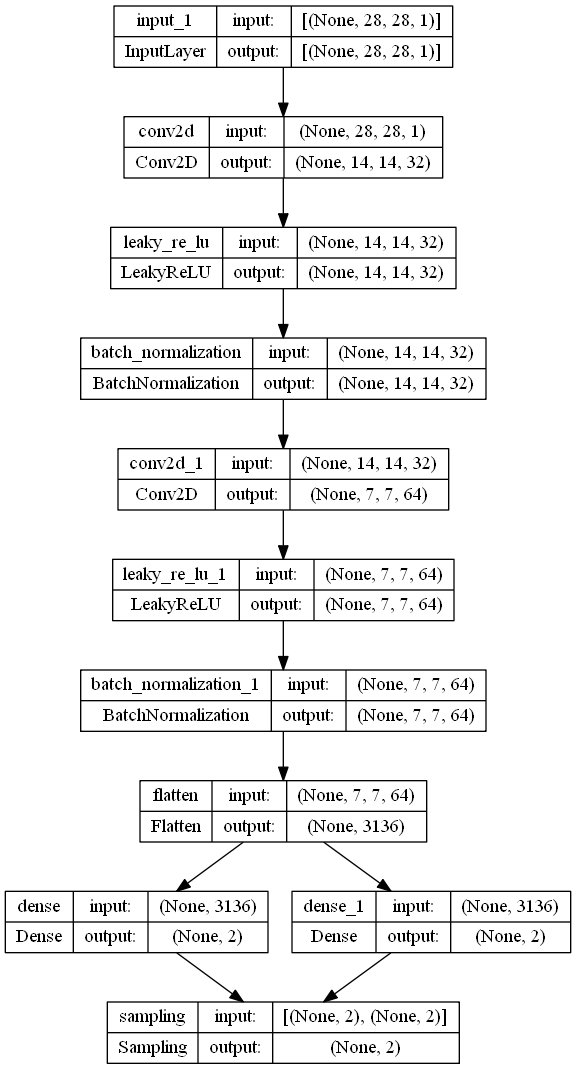

In [6]:
inputs = Input(shape = (WIDTH, HEIGHT, NUM_CHANNELS))
    
# Encoder    
encoder = Conv2D(32, (3, 3), strides=2, padding="same")(inputs)
encoder = LeakyReLU(alpha=0.2)(encoder)
encoder = BatchNormalization()(encoder)

encoder = Conv2D(64, (3, 3), strides=2, padding="same")(encoder)
encoder = LeakyReLU(alpha=0.2)(encoder)
encoder = BatchNormalization()(encoder)

volumeSize = encoder.shape
encoder = Flatten()(encoder)
z_mean = Dense(LATENT_DIM)(encoder)
z_logvar = Dense(LATENT_DIM)(encoder)
z_layer = Sampling()([z_mean, z_logvar])

encoder = Model(inputs, [z_layer, z_mean, z_logvar], name = 'encoder')

tf.keras.utils.plot_model(encoder,show_shapes=True)

## Decoder Model

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                           

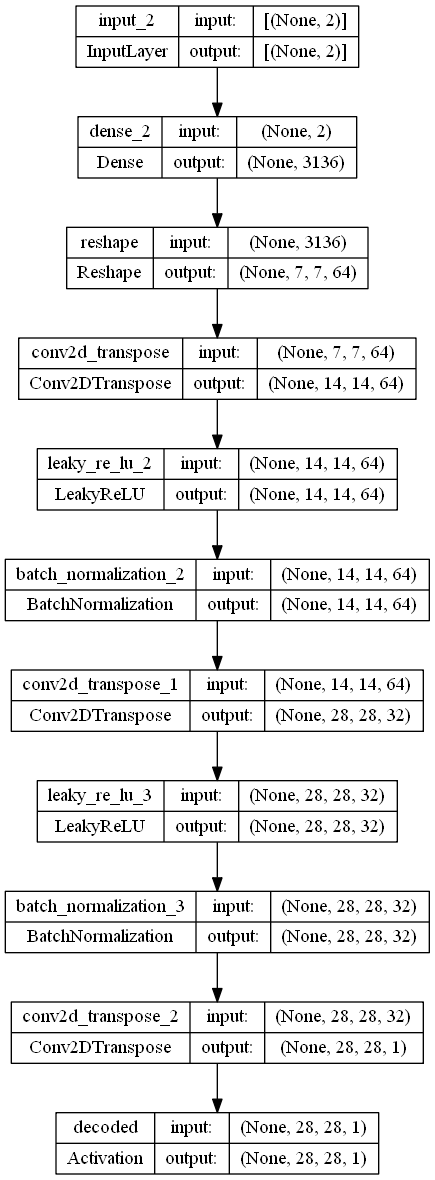

In [7]:
#decoder
z_input = Input(shape=(LATENT_DIM,))
decoder = Dense(np.prod(volumeSize[1:]))(z_input)
decoder = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(decoder)

decoder = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(decoder)
decoder = LeakyReLU(alpha=0.2)(decoder)
decoder = BatchNormalization()(decoder) 

decoder = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(decoder)
decoder = LeakyReLU(alpha=0.2)(decoder)
decoder = BatchNormalization()(decoder)    

decoder = Conv2DTranspose(NUM_CHANNELS, (3, 3), padding="same")(decoder)
outputs = Activation("sigmoid", name="decoded")(decoder)

decoder = Model(z_input, outputs, name="decoder")
decoder.summary()

tf.keras.utils.plot_model(decoder,show_shapes=True)

## Build the full model

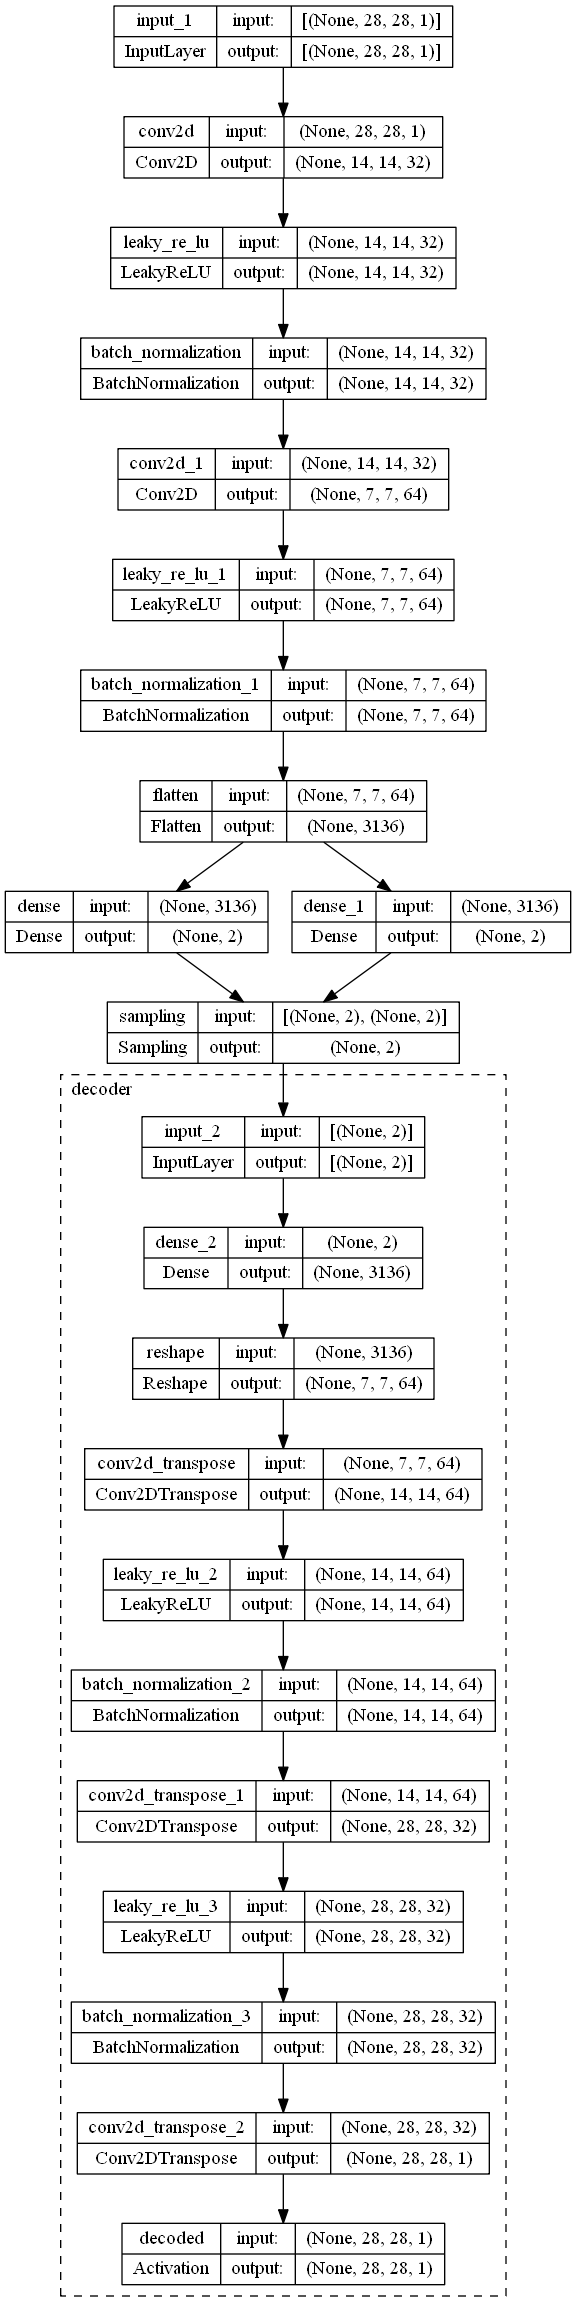

In [8]:
vae = Model(inputs, decoder(z_layer))
tf.keras.utils.plot_model(vae,show_shapes=True, expand_nested=True)

# Train cycle

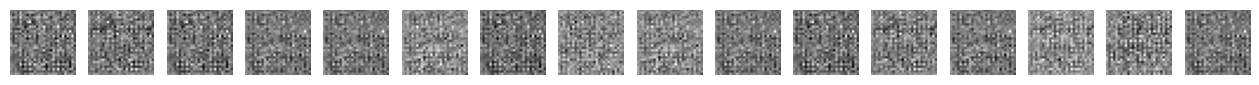

In [9]:
num_examples_to_generate = 16
random_latent_vector = tf.random.normal(
    shape=[num_examples_to_generate, LATENT_DIM])

generate_and_save_images(
            decoder, 0, random_latent_vector)

## Loss function

The loss function has two components: 

- **reconstruction loss** - this is similar to an normal autoencoder. This term measures the discrepancy between the obtained output and the desired output, and its purpose is to obtain a more faithful reconstruction
- **KL loss**: this is the Kullback-Leibler (KL) divergence between the learned distribution of the latent variables and a known prior distribution (typically a standard normal distribution). The goal is to obtain a distribution as close as possible to the prior distribution, thereby ensuring that the latent space can be better explored. 

reconstruction loss = $1/N \sum (train_x - output)^2$

For the KL Loss we are considering the prior to be a Normal distribution with $\mu = 0$ and $\sigma = 1$

KL loss = $1/N \sum - 0.5 \times log(\sigma^2) - \mu^2 - e^{log(\sigma^2)}$

loss = reconstruction loss + KL loss

Epoch 1, loss: 46.167259216308594, reconst loss: 43.356136322021484, KL loss: 2.811166763305664
Epoch 2, loss: 42.66054916381836, reconst loss: 39.28739547729492, KL loss: 3.373239278793335
Epoch 3, loss: 41.899864196777344, reconst loss: 38.32137680053711, KL loss: 3.578476905822754
Epoch 4, loss: 41.4821662902832, reconst loss: 37.779571533203125, KL loss: 3.7026147842407227
Epoch 5, loss: 41.24215316772461, reconst loss: 37.4539794921875, KL loss: 3.7882585525512695


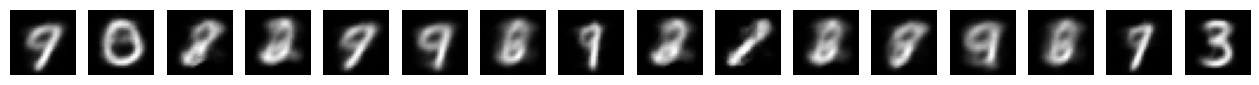

Epoch 6, loss: 41.03174591064453, reconst loss: 37.20753860473633, KL loss: 3.8241941928863525
Epoch 7, loss: 40.886417388916016, reconst loss: 37.0120964050293, KL loss: 3.87428879737854
Epoch 8, loss: 40.74726104736328, reconst loss: 36.82565689086914, KL loss: 3.921633243560791
Epoch 9, loss: 40.63156509399414, reconst loss: 36.650047302246094, KL loss: 3.981515884399414
Epoch 10, loss: 40.51463317871094, reconst loss: 36.518760681152344, KL loss: 3.9958248138427734


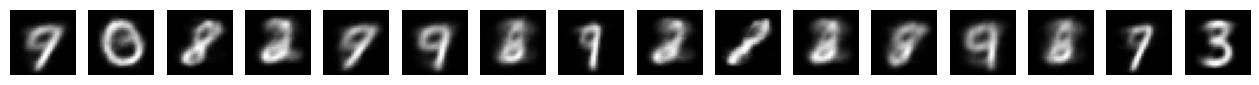

Epoch 11, loss: 40.413108825683594, reconst loss: 36.39118576049805, KL loss: 4.021910190582275
Epoch 12, loss: 40.3270149230957, reconst loss: 36.30479431152344, KL loss: 4.0222368240356445
Epoch 13, loss: 40.240753173828125, reconst loss: 36.16158676147461, KL loss: 4.0791168212890625
Epoch 14, loss: 40.2014274597168, reconst loss: 36.10914611816406, KL loss: 4.092251300811768
Epoch 15, loss: 40.083805084228516, reconst loss: 35.978214263916016, KL loss: 4.105627536773682


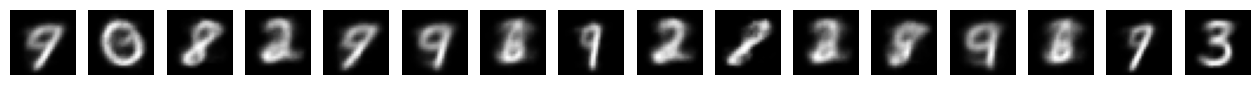

Epoch 16, loss: 40.0204963684082, reconst loss: 35.90308380126953, KL loss: 4.117424011230469
Epoch 17, loss: 39.94304275512695, reconst loss: 35.810157775878906, KL loss: 4.132962226867676
Epoch 18, loss: 39.920841217041016, reconst loss: 35.760887145996094, KL loss: 4.160031318664551
Epoch 19, loss: 39.86376953125, reconst loss: 35.711551666259766, KL loss: 4.152225017547607
Epoch 20, loss: 39.81321716308594, reconst loss: 35.63397979736328, KL loss: 4.1792402267456055


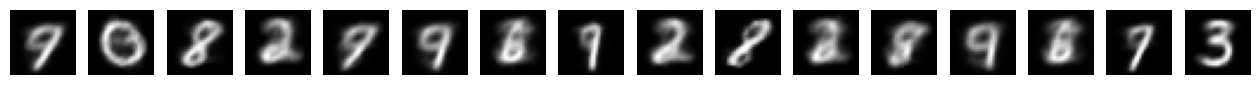

Epoch 21, loss: 39.73907470703125, reconst loss: 35.5589485168457, KL loss: 4.180088043212891
Epoch 22, loss: 39.71396255493164, reconst loss: 35.5192756652832, KL loss: 4.1947245597839355
Epoch 23, loss: 39.69644546508789, reconst loss: 35.48200988769531, KL loss: 4.2144389152526855
Epoch 24, loss: 39.64472198486328, reconst loss: 35.43988800048828, KL loss: 4.204793453216553
Epoch 25, loss: 39.60020065307617, reconst loss: 35.38441848754883, KL loss: 4.215804100036621


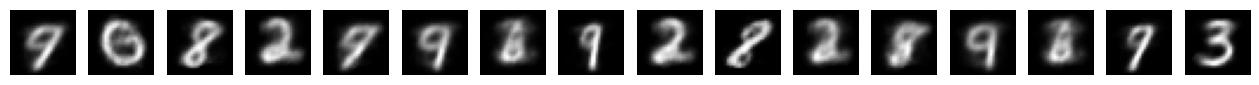

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

EPOCHS = 25

@tf.function
def train_step(encoder, decoder, train_x, optimizer):

    with tf.GradientTape() as tape:
        
        z, z_mean, z_logvar = encoder(train_x)
        x = decoder(z)
        
        kl_loss = -0.5 * (1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))  

        reconstruction_loss = tf.reduce_sum(tf.keras.losses.mse(train_x, x), axis=(1, 2))
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)        
        
        loss = kl_loss + reconstruction_loss
        
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))

    return loss, kl_loss, reconstruction_loss


if train_online:
    for epoch in range(1, EPOCHS + 1):
        
        epoch_loss = 0
        rec_loss = 0
        kls_loss = 0
        batch = 0
        
        for train_x, _ in train_dataset:
            
            loss, kl_loss, reconstruction_loss = train_step(encoder, decoder, train_x, optimizer)
            
            epoch_loss += tf.reduce_mean(loss)
            kls_loss += tf.reduce_mean(kl_loss)
            rec_loss += tf.reduce_mean(reconstruction_loss)
            batch += 1
        print(f'Epoch {epoch}, loss: {epoch_loss/batch}, reconst loss: {rec_loss/batch}, KL loss: {kls_loss/batch}')
        if epoch % 5 == 0:
            generate_and_save_images(
                decoder, epoch, random_latent_vector)

In [20]:
epoch = EPOCHS

if train_online:
    vae.save_weights(f'{models_path}/vae_weights/vae_{epoch}.weights')
    
vae.load_weights(f'{models_path}/vae_weights/vae_{epoch}.weights')

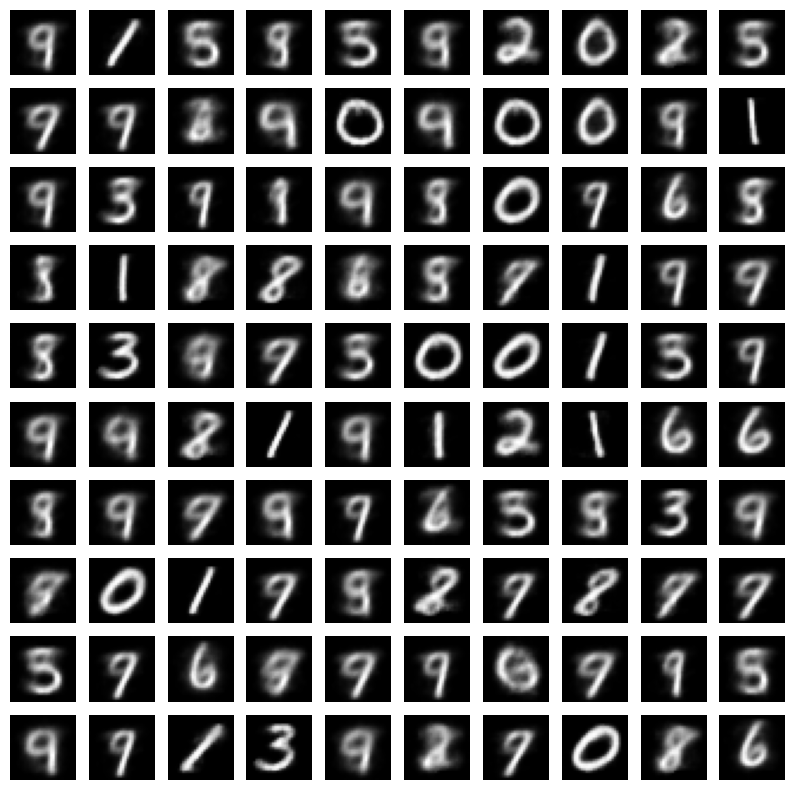

In [21]:
samples = []

for train_x, _ in train_dataset:
    z, mean, logvar = encoder(train_x)
    samples.extend(decoder(z).numpy())
    
show_samples(samples[:100])    

The percentage of values that lie within an interval estimate in a normal distribution: 68%, 95%, and 99.7% of the values lie within one, two, and three standard deviations of the mean, respectively.

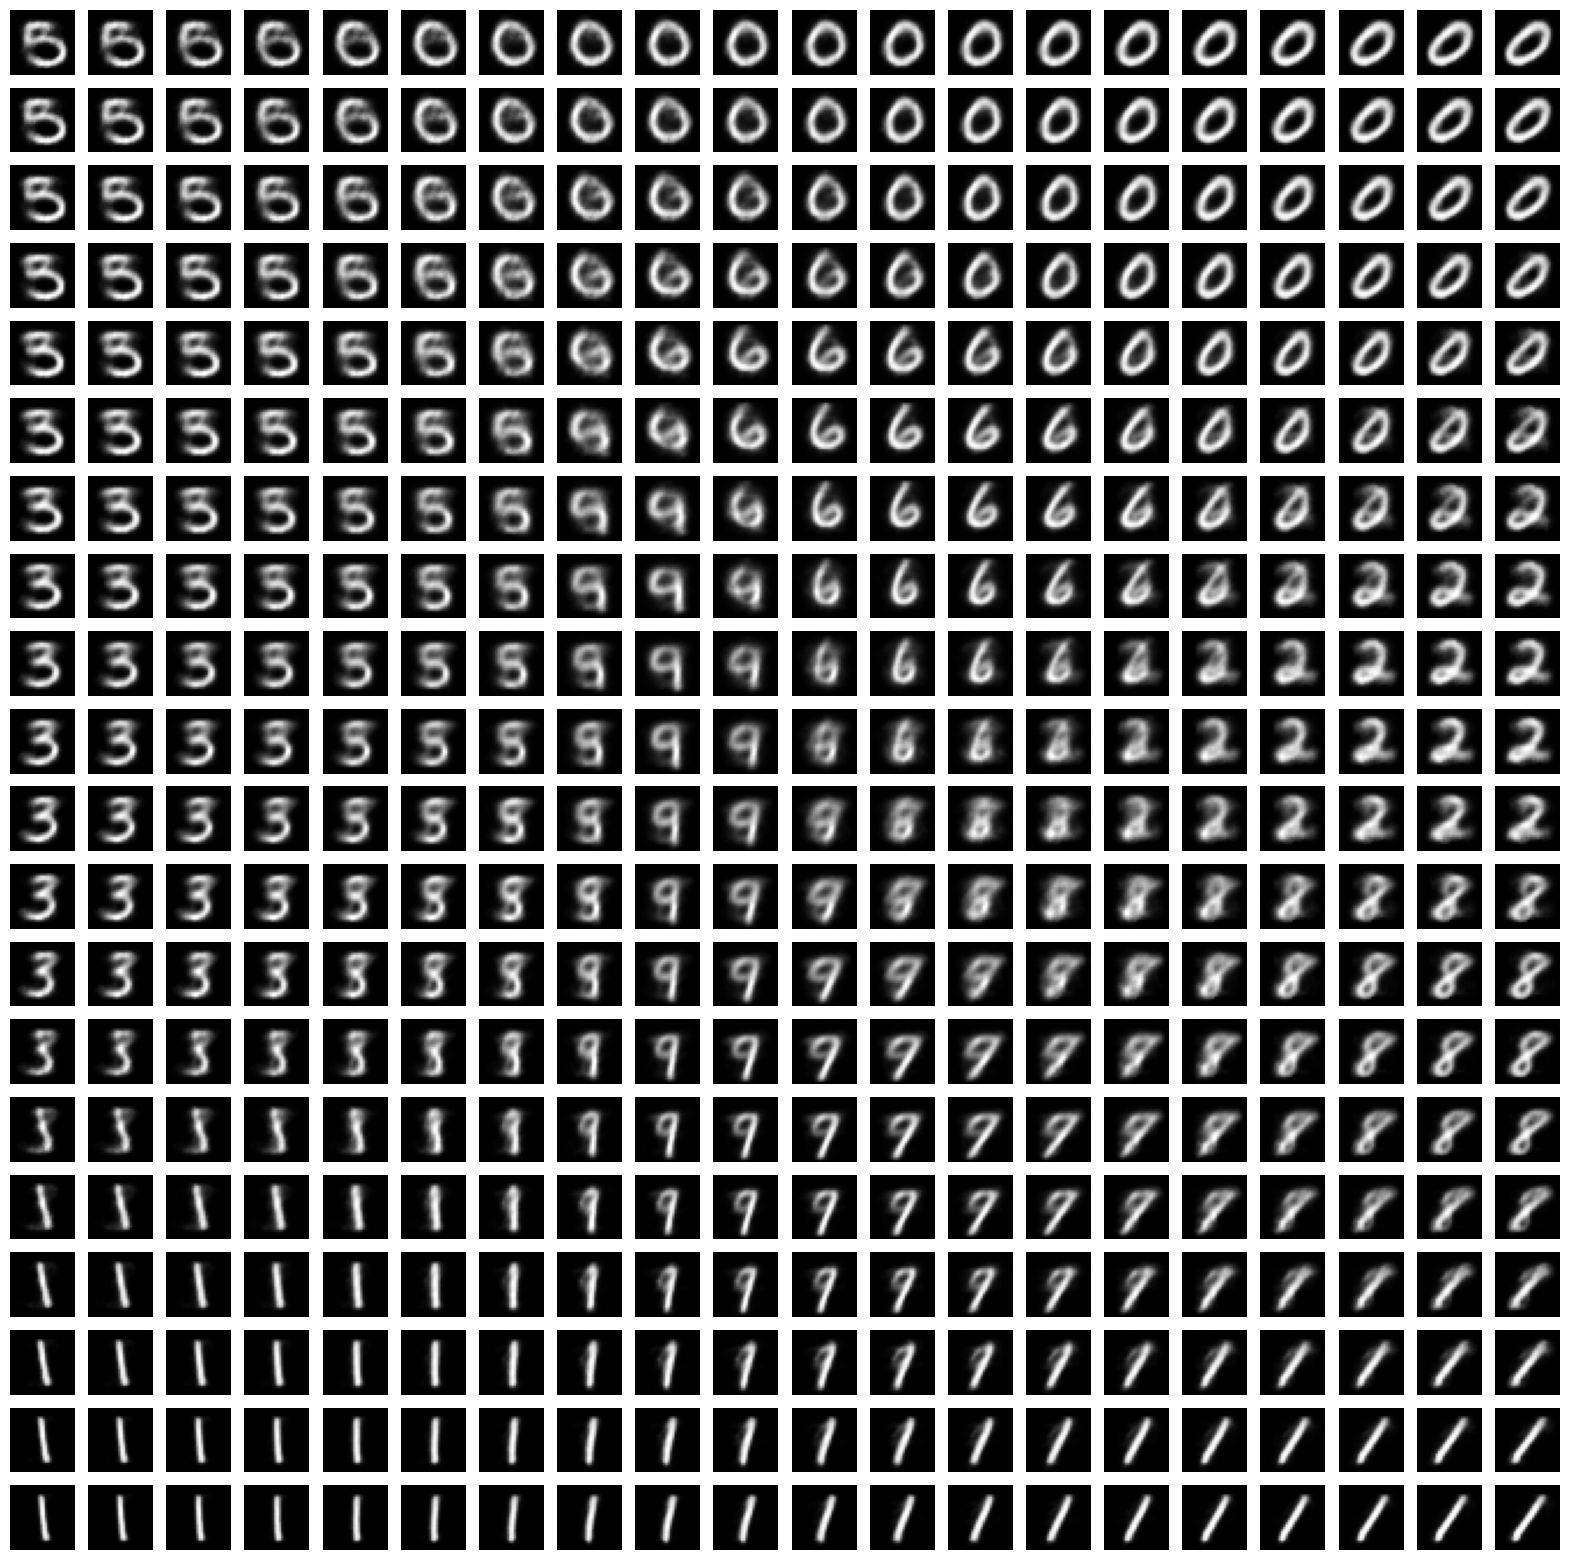

In [22]:
vector_generation = []
for i in range(20):
    for j in range(20):
        vector_generation.append([-2.0 + i*0.2, -2.0 + j*0.2])

predictions = decoder(np.asarray(vector_generation))

show_samples(predictions)

1875/1875 [==============================] - 7s 2ms/step


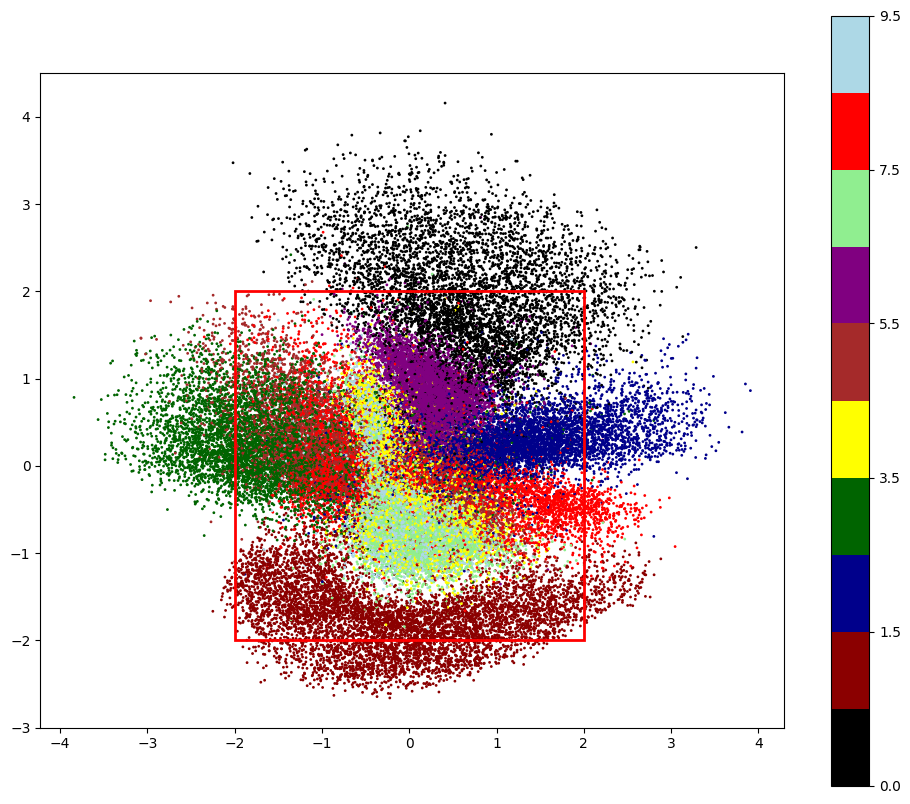

In [23]:
encoded = encoder.predict(train_X)

x = np.array(encoded)[1][:,0]
y = np.array(encoded)[1][:,1]
    
# to match the above plot we are plotting (y,-x)    
plot_scatter(y,-x,train_Y)
   
    
